In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import umap
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from operator import itemgetter

from sklearn.base import clone
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


2025-08-27 13:08:29.502758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/easybuild/software/Python/3.10.4-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/OpenSSL/1.1/lib:/cm/shared/easybuild/software/libffi/3.4.2-GCCcore-11.3.0/lib64:/cm/shared/easybuild/software/GMP/6.2.1-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/XZ/5.2.5-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/SQLite/3.38.3-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/Tcl/8.6.12-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/libreadline/8.1.2-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/ncurses/6.3-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/bzip2/1.0.8-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/binutils/2.38-GCCcore-11.3.0/lib:/cm/shared/easybuild/software/zlib/1.2.12-GCCcore-11.3.0/lib:/cm/shared/easybuild/softw

In [2]:
dists = pd.read_csv("/mnt/isilon/tan_lab/xiongb/NOrbitRevision/intermediates/TNBC/CytoCommunity/neighborhood_distance_matrix.csv", index_col=0)
dists

,NT001_Baseline_1460_1,NT001_Baseline_1460_2,NT001_Baseline_1460_3,NT001_Baseline_1460_4,NT001_Baseline_1460_5,NT001_Baseline_1460_6,NT001_Baseline_1460_7,NT001_Baseline_1461_1,NT001_Baseline_1461_2,NT001_Baseline_1461_3,...,NT279_Post-treatment_418_8,NT279_Post-treatment_422_3,NT279_Post-treatment_422_4,NT279_Post-treatment_422_5,NT279_Post-treatment_422_6,NT279_Post-treatment_422_8,NT279_Post-treatment_425_4,NT279_Post-treatment_425_5,NT279_Post-treatment_425_6,NT279_Post-treatment_425_8
NT001_Baseline_1460_1,0.000000,2.406238,2.171586,2.056371,2.648958,2.811367,2.133253,2.377014,2.207342,2.134720,...,9.417938,7.442005,7.048491,5.103410,4.788070,6.262612,4.952937,5.212187,7.545512,5.067069
NT001_Baseline_1460_2,2.406238,0.000000,1.550606,2.293187,2.046949,3.418155,1.849556,2.021935,0.959950,2.049979,...,9.887547,8.205386,7.811872,5.666255,5.551407,6.982624,5.685257,5.975568,8.172034,5.830449
NT001_Baseline_1460_3,2.171586,1.550606,0.000000,1.995451,1.634979,2.691355,1.295294,2.080943,1.496990,1.914478,...,9.555076,7.616675,7.223161,5.081237,4.962696,6.393925,5.096546,5.386857,7.596040,5.241738
NT001_Baseline_1460_4,2.056371,2.293187,1.995451,0.000000,2.272269,3.035356,1.647850,2.084591,2.194002,1.714096,...,9.526447,7.817359,7.423845,5.562142,5.163381,6.621079,5.404450,5.587542,7.946509,5.442423
NT001_Baseline_1460_5,2.648958,2.046949,1.634979,2.272269,0.000000,3.190716,2.007809,2.108067,2.075985,1.864460,...,10.090470,8.306990,7.913476,5.811908,5.653011,7.084228,5.786861,6.077172,8.273640,5.932053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT279_Post-treatment_422_8,6.262612,6.982624,6.393925,6.621079,7.084228,7.002264,5.852730,7.487003,6.614753,6.887947,...,5.729924,3.018428,2.487149,2.301435,2.886863,0.000000,2.445937,2.698902,4.006162,2.278094
NT279_Post-treatment_425_4,4.952937,5.685257,5.096546,5.404450,5.786861,5.780002,4.555491,6.263687,5.317386,5.685344,...,6.245673,3.796266,3.493297,1.355484,1.327567,2.445937,0.000000,1.464117,4.092046,1.757731
NT279_Post-treatment_425_5,5.212187,5.975568,5.386857,5.587542,6.077172,5.980681,4.845673,6.553998,5.607697,5.861646,...,6.508867,3.873491,3.708381,2.005864,2.008055,2.698902,1.464117,0.000000,4.348294,1.221253
NT279_Post-treatment_425_6,7.545512,8.172034,7.596040,7.946509,8.273640,8.330744,7.223581,8.750464,7.804178,8.339933,...,4.753619,3.721690,4.243339,4.153232,4.981848,4.006162,4.092046,4.348294,0.000000,4.180069


In [3]:
clinical = pd.read_csv("/mnt/isilon/tan_lab/xiongb/tcn/public/NTPublic/data/derived/clinical.csv")
clinical = clinical[["PatientID","pCR","Arm"]].drop_duplicates().sort_values("PatientID").reset_index(drop=True)

In [4]:
data = pd.read_csv("/home/xiongb/Documents/tcn/NOrbit/data/wang_breast_neighborhoods_cytocommunity_revised.csv")
maxTCN = np.max(data["TCN_Label"])
data["image_neighborhood"] = data['Image'] + "_" + data["TCN_Label"].astype(str)
data["Percent"] = 1
data = pd.DataFrame(data.groupby(["Image","image_neighborhood"]).count()["Percent"]/data.groupby(["Image"]).count()["Percent"])
data = data.reset_index().set_index("image_neighborhood")
data["Count"] = 1

In [5]:
comp = pd.read_csv("/home/xiongb/Documents/tcn/NOrbit/data/wang_breast_neighborhoods_cytocommunity_revised.csv")
comp["image_neighborhood"] = comp['Image'] + "_" + comp["TCN_Label"].astype(str)
comp["Percent"] = 1
cts= sorted(set(comp["Cell_Type"]))
comp = pd.DataFrame(comp.groupby(["image_neighborhood","Cell_Type"]).count()["Percent"]/comp.groupby(["image_neighborhood"]).count()["Percent"])
comp = comp.reset_index()
comp = pd.pivot(comp,index="image_neighborhood",columns="Cell_Type",values="Percent").fillna(0).reset_index()
comp

Cell_Type,image_neighborhood,AR^{+}LAR,Apoptosis,Basal,CA9^+,CA9^{+}Hypoxia,CD15^{+},CD20^+B,CD4^+PD1^+T,CD4^+TCF1^+T,...,PD-L1^+APCs,PD-L1^+IDO^+APCs,PD-L1^{+}GZMB^{+},PD-L1^{+}IDO^{+},PDPN^+Stromal,TCF1^{+},Treg,Vimentin^{+}EMT,pH2AX^{+}DSB,panCK^{med}
0,NT001_Baseline_1460_1,0.0,0.020408,0.000000,0.0,0.0,0.020408,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.102041,0.0,0.571429,0.040816,0.142857
1,NT001_Baseline_1460_2,0.0,0.002301,0.006904,0.0,0.0,0.001151,0.0,0.000000,0.000000,...,0.0,0.0,0.001151,0.0,0.000000,0.051784,0.0,0.620253,0.032221,0.008055
2,NT001_Baseline_1460_3,0.0,0.004651,0.000000,0.0,0.0,0.009302,0.0,0.000000,0.000000,...,0.0,0.0,0.004651,0.0,0.000000,0.051163,0.0,0.516279,0.153488,0.037209
3,NT001_Baseline_1460_4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.048780,0.0,0.640244,0.109756,0.121951
4,NT001_Baseline_1460_5,0.0,0.000000,0.004878,0.0,0.0,0.017073,0.0,0.000000,0.000000,...,0.0,0.0,0.002439,0.0,0.000000,0.053659,0.0,0.395122,0.324390,0.068293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15407,NT279_Post-treatment_425_4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.004608,0.009217,...,0.0,0.0,0.000000,0.0,0.004608,0.000000,0.0,0.000000,0.000000,0.000000
15408,NT279_Post-treatment_425_5,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.009259,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
15409,NT279_Post-treatment_425_6,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.016949,0.033898,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
15410,NT279_Post-treatment_425_7,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [6]:
reducer = umap.UMAP(metric="precomputed",n_components=2,random_state=0)
reduced = reducer.fit_transform(dists.values)
umapDF = pd.DataFrame({"image_neighborhood":dists.index,"UMAP 1":reduced[:,0],"UMAP 2":reduced[:,1]})
umapDF["PatientID"] = [i.split("_")[0] for i in dists.index]
umapDF["Phase"] = [i.split("_")[1] for i in dists.index]
umapDF["Image"] = ["_".join(i.split("_")[:3]) for i in dists.index]
umapDF = umapDF.merge(clinical,on="PatientID")
umapDF["Phase_pCR"] = umapDF["Phase"] + "_" + umapDF["pCR"]
umapDF = umapDF.merge(data[["Percent","Count"]], left_on="image_neighborhood", right_index=True)
umapDF = umapDF.merge(comp, on="image_neighborhood")


/home/xiongb/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/xiongb/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [7]:
umapDF.to_csv("TNBC-Immuno-UMAP-NOrbit.csv")

In [8]:
ki67 = pd.read_csv("/home/xiongb/Documents/tcn/NOrbit/data/wang_breast_neighborhoods_cytocommunity_revised.csv")
ki67 = ki67[["Image","TCN_Label","Cell_Type","Ki67"]]
ki67["Cell_Type"] = ki67["Cell_Type"] + " Ki67"
cts_ki67 = sorted(set(ki67["Cell_Type"]))
ki67["image_neighborhood"] = ki67["Image"] +"_" + ki67["TCN_Label"].astype(str)
ki67["Ki67"] = (ki67["Ki67"]>(10**(-5))).astype(int)
ki67 = pd.DataFrame(ki67.groupby(["image_neighborhood","Cell_Type"])["Ki67"].mean()).reset_index()
ki67 = ki67.pivot(index='image_neighborhood',columns='Cell_Type',values='Ki67').fillna(0)
ki67 = ki67.reset_index()
ki67

Cell_Type,image_neighborhood,AR^{+}LAR Ki67,Apoptosis Ki67,Basal Ki67,CA9^+ Ki67,CA9^{+}Hypoxia Ki67,CD15^{+} Ki67,CD20^+B Ki67,CD4^+PD1^+T Ki67,CD4^+TCF1^+T Ki67,...,PD-L1^+APCs Ki67,PD-L1^+IDO^+APCs Ki67,PD-L1^{+}GZMB^{+} Ki67,PD-L1^{+}IDO^{+} Ki67,PDPN^+Stromal Ki67,TCF1^{+} Ki67,Treg Ki67,Vimentin^{+}EMT Ki67,pH2AX^{+}DSB Ki67,panCK^{med} Ki67
0,NT001_Baseline_1460_1,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.678571,1.000000,0.714286
1,NT001_Baseline_1460_2,0.0,1.0,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.844444,0.0,0.792208,0.785714,0.857143
2,NT001_Baseline_1460_3,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.810811,0.939394,1.000000
3,NT001_Baseline_1460_4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.875000,0.0,0.828571,0.944444,0.750000
4,NT001_Baseline_1460_5,0.0,0.0,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,0.814815,0.932331,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15407,NT279_Post-treatment_425_4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
15408,NT279_Post-treatment_425_5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
15409,NT279_Post-treatment_425_6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
15410,NT279_Post-treatment_425_7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


<AxesSubplot: xlabel='UMAP 1', ylabel='UMAP 2'>

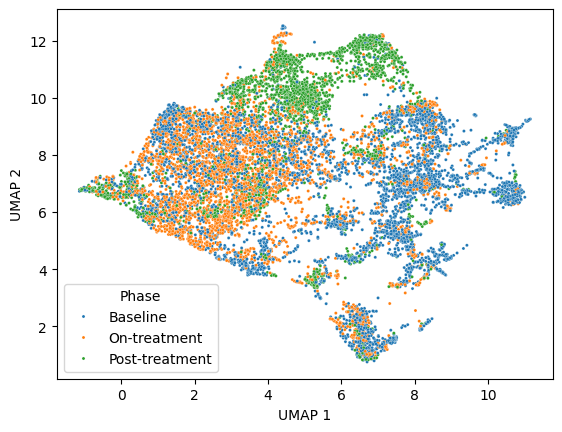

In [9]:
sns.scatterplot(umapDF,x="UMAP 1", y="UMAP 2",hue="Phase",s=5)

<AxesSubplot: xlabel='UMAP 1', ylabel='UMAP 2'>

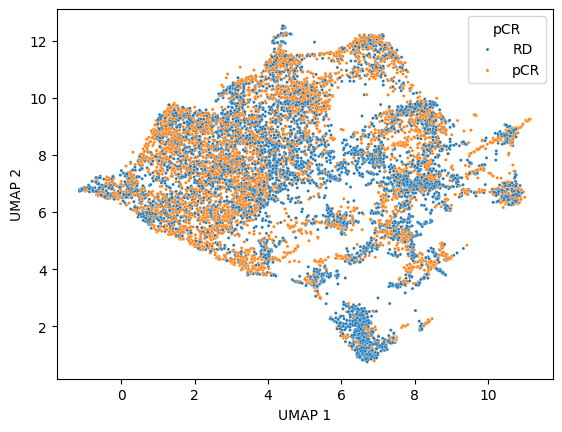

In [10]:
sns.scatterplot(umapDF,x="UMAP 1", y="UMAP 2",hue="pCR",s=5)

In [11]:
feat = 10
reducer = PCA(n_components=feat, random_state=0)
matrix_transformed = reducer.fit_transform(dists.values)
neighborhood_latent = pd.DataFrame(matrix_transformed, index = dists.index)
neighborhood_latent["phase"] = [i.split("_")[1] for i in neighborhood_latent.index]
dummies = pd.get_dummies(neighborhood_latent["phase"])
neighborhood_latent["Baseline"] = dummies["Baseline"].astype(int)
neighborhood_latent["On-treatment"] = dummies["On-treatment"].astype(int)
neighborhood_latent["Post-treatment"] = dummies["Post-treatment"].astype(int)
neighborhood_latent["Phase_num"] = neighborhood_latent["On-treatment"]+2*neighborhood_latent["Post-treatment"]

neighborhood_latent["patient"] = [i.split("_")[0] for i in neighborhood_latent.index]
neighborhood_latent["Image"] = ["_".join(i.split("_")[:3]) for i in neighborhood_latent.index]
clinical = clinical[["PatientID","pCR","Arm"]].drop_duplicates()
neighborhood_latent = neighborhood_latent.merge(clinical[["PatientID","pCR","Arm"]], left_on="patient",right_on="PatientID", how="left")
neighborhood_latent["pCR_Arm"] = neighborhood_latent["pCR"] + "_" + neighborhood_latent["Arm"]
neighborhood_latent["Arm"] = [int(i == "C&I") for i in neighborhood_latent["Arm"]]
neighborhood_latent["pCRbin"] = [int(i == "pCR") for i in neighborhood_latent["pCR"]]
neighborhood_latent["patient_phase"] = neighborhood_latent["patient"] + "_" + neighborhood_latent["phase"]
neighborhood_latent.columns = neighborhood_latent.columns.astype(str)
neighborhood_latent["image_neighborhood"] = dists.index
neighborhood_latent = neighborhood_latent.merge(ki67, on="image_neighborhood")
neighborhood_latent = neighborhood_latent.merge(comp, on="image_neighborhood")

neighborhood_latent

,0,1,2,3,4,5,6,7,8,9,...,PD-L1^+APCs,PD-L1^+IDO^+APCs,PD-L1^{+}GZMB^{+},PD-L1^{+}IDO^{+},PDPN^+Stromal,TCF1^{+},Treg,Vimentin^{+}EMT,pH2AX^{+}DSB,panCK^{med}
0,-10.304938,141.308278,-2.604546,8.496751,-0.219527,37.154983,-1.630431,10.759644,2.693948,-27.725581,...,0.0,0.0,0.000000,0.0,0.000000,0.102041,0.00000,0.571429,0.040816,0.142857
1,47.523101,164.429849,-25.394700,11.478922,-0.869865,40.347902,7.127084,-3.407644,12.377374,-23.602697,...,0.0,0.0,0.001151,0.0,0.000000,0.051784,0.00000,0.620253,0.032221,0.008055
2,-2.787353,148.441727,-2.935009,11.575270,2.190089,42.762121,1.829034,0.951447,7.708458,-22.027273,...,0.0,0.0,0.004651,0.0,0.000000,0.051163,0.00000,0.516279,0.153488,0.037209
3,18.513525,157.936942,-8.214945,6.492548,1.995674,36.178977,-4.190258,1.952103,9.873617,-30.933316,...,0.0,0.0,0.000000,0.0,0.000000,0.048780,0.00000,0.640244,0.109756,0.121951
4,54.706093,173.576711,-21.954535,6.189598,1.822070,39.317104,2.434620,-1.300980,13.779488,-23.480481,...,0.0,0.0,0.002439,0.0,0.000000,0.053659,0.00000,0.395122,0.324390,0.068293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11866,-147.462367,-33.581587,-10.007886,-11.019797,3.654168,-6.351511,18.207861,7.847869,18.400249,4.655607,...,0.0,0.0,0.000000,0.0,0.027682,0.000000,0.00346,0.000000,0.000000,0.000000
11867,-194.827961,0.175018,-7.795300,16.380977,0.303083,12.248264,11.785126,9.921712,4.441874,-0.896473,...,0.0,0.0,0.000000,0.0,0.004608,0.000000,0.00000,0.000000,0.000000,0.000000
11868,-190.396468,4.209548,12.657536,21.748226,3.230328,6.858400,10.044775,7.735558,9.017295,-0.663582,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11869,-25.962344,-70.998136,-37.445183,10.745615,2.389099,6.381091,8.210477,22.506156,30.521887,4.089288,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [12]:
interactions = []
for i in range(feat):
    s = neighborhood_latent[str(i)]
    neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
    neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
    neighborhood_latent["Post-treatment*"+str(i)] = neighborhood_latent["Post-treatment"]*s
    interactions.append("Baseline*"+str(i))
    interactions.append("On-treatment*"+str(i))
    interactions.append("Post-treatment*"+str(i))
    
for i in cts:
    s = neighborhood_latent[str(i)]
    neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
    neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
    neighborhood_latent["Post-treatment*"+str(i)] = neighborhood_latent["Post-treatment"]*s
    interactions.append("Baseline*"+str(i))
    interactions.append("On-treatment*"+str(i))
    interactions.append("Post-treatment*"+str(i))

for i in cts_ki67:
    s = neighborhood_latent[str(i)]
    neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
    neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
    neighborhood_latent["Post-treatment*"+str(i)] = neighborhood_latent["Post-treatment"]*s
    interactions.append("Baseline*"+str(i))
    interactions.append("On-treatment*"+str(i))
    interactions.append("Post-treatment*"+str(i))

/tmp/ipykernel_1923910/2533648198.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
/tmp/ipykernel_1923910/2533648198.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
/tmp/ipykernel_1923910/2533648198.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [13]:
# Make splits by patient
patient_splits = [i[1][1] for i in enumerate(KFold(n_splits=4, shuffle=True, random_state=0).split(range(279)))]
splits = []
# Train and validation rolling splits
for i in patient_splits[:-1]:
    indices = []
    for p in i:
        ind = [index for index,value in enumerate(neighborhood_latent["image_neighborhood"]) if clinical.iloc[p]["PatientID"] in value]
        indices.extend(ind)
    notIndices = [i for i in range(len(neighborhood_latent.index)) if i not in indices]
    splits.append((notIndices,indices))
    
# Test split
test_split = []
for i in patient_splits[-1:]:
    indices = []
    for p in i:
        ind = [index for index,value in enumerate(neighborhood_latent["image_neighborhood"]) if clinical.iloc[p]["PatientID"] in value]
        indices.extend(ind)
    notIndices = [i for i in range(len(neighborhood_latent.index)) if i not in indices]
    test_split.append((notIndices,indices))

In [14]:
columns = interactions

from sklearn.base import clone
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


scaler = StandardScaler()
scaled = scaler.fit_transform(neighborhood_latent[columns])


scores = []
coefs = []
results = {"image_neighborhood":[],"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[]}
for (train_index, test_index) in splits:
    clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                             max_iter=10000)
    clf.fit(scaled[train_index],np.array(neighborhood_latent["pCRbin"])[train_index])
    predictions = clf.predict(scaled[test_index])
    confidences = clf.decision_function(scaled[test_index])
    probabilities = clf.predict_proba(scaled[test_index])
    for i in range(len(test_index)):
        results["image_neighborhood"].append(neighborhood_latent.iloc[test_index[i]]["image_neighborhood"])
        results["Prediction"].append(predictions[i])
        results["Actual"].append(neighborhood_latent.iloc[test_index[i]]["pCRbin"])
        results["Correct"].append(int(predictions[i]==neighborhood_latent.iloc[test_index[i]]["pCRbin"]))
        results["Phase"].append(neighborhood_latent.iloc[test_index[i]]["phase"])
        results["Patient"].append(neighborhood_latent.iloc[test_index[i]]["patient"])
        results["Image"].append(neighborhood_latent.iloc[test_index[i]]["Image"])
        results["Confidences"].append(confidences[i])
        results["Probabilities"].append(probabilities[i][0])
    print(np.mean(results["Correct"]))
    coefs.append(clf.coef_)

results = pd.DataFrame(results)
print(results.groupby("Phase")["Correct"].mean())
print(results["Correct"].mean())

0.6672449687716864
0.6438593452277845
0.6445201590005678
Phase
Baseline          0.606124
On-treatment      0.662680
Post-treatment    0.688930
Name: Correct, dtype: float64
0.6445201590005678


In [15]:
import math
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests


coefDF = pd.DataFrame({"Features":columns, "Mean Coef":np.mean(coefs,axis=0)[0], "SD Coef": np.std(coefs,axis=0)[0]})
coefDF["Abs Coef"] = np.abs(coefDF["Mean Coef"])
coefDF = coefDF.sort_values("Abs Coef",ascending=False)
coefDF["Std Error Coef"] = coefDF["SD Coef"]/math.sqrt(15)
coefDF["Z"] = coefDF["Mean Coef"]/coefDF["Std Error Coef"] 
coefDF["Abs Z"] = np.abs(coefDF["Z"])
coefDF["p_values"] = 2 * (1 - norm.cdf(np.abs(coefDF["Z"])))
coefDF["bonferroni_p"] = multipletests(coefDF["p_values"], method="bonferroni")[1]
coefDF = coefDF.sort_values("Abs Z", ascending=False)
sigvars = list(coefDF[(coefDF["Abs Coef"] > 0.075)&(coefDF["bonferroni_p"]<0.05)]['Features'])
coefDF[coefDF["Abs Coef"] > 0.075].sort_values("Abs Coef",ascending=False)

,Features,Mean Coef,SD Coef,Abs Coef,Std Error Coef,Z,Abs Z,p_values,bonferroni_p
41,Post-treatment*CA9^+,-0.803491,0.218451,0.803491,0.056404,-14.245325,14.245325,0.000000e+00,0.000000e+00
131,Post-treatment*Treg,-0.527229,0.039135,0.527229,0.010105,-52.176761,52.176761,0.000000e+00,0.000000e+00
31,On-treatment*AR^{+}LAR,-0.515513,0.026909,0.515513,0.006948,-74.196028,74.196028,0.000000e+00,0.000000e+00
8,Post-treatment*2,-0.439681,0.080941,0.439681,0.020899,-21.038413,21.038413,0.000000e+00,0.000000e+00
133,On-treatment*Vimentin^{+}EMT,-0.411683,0.227348,0.411683,0.058701,-7.013220,7.013220,2.329026e-12,5.869145e-10
...,...,...,...,...,...,...,...,...,...
23,Post-treatment*7,-0.077252,0.017582,0.077252,0.004540,-17.017031,17.017031,0.000000e+00,0.000000e+00
210,Baseline*M2 Mac Ki67,-0.077146,0.012425,0.077146,0.003208,-24.046454,24.046454,0.000000e+00,0.000000e+00
83,Post-treatment*CK^{hi}GATA3^{+},-0.075964,0.035676,0.075964,0.009212,-8.246586,8.246586,2.220446e-16,5.595524e-14
18,Baseline*6,0.075594,0.049852,0.075594,0.012872,5.872802,5.872802,4.284914e-09,1.079798e-06


In [16]:
sigvarsDF = pd.DataFrame({"Name":sigvars,"Treatment Phase": [i.split("*")[0] for i in sigvars],
                        "Feature": [i.split("*")[1].split(" ")[0] for i in sigvars],
                          "Type": [i.split("*")[1].split(" ")[-1] for i in sigvars],
                          "Abs Coef": [list(coefDF[coefDF["Features"]==i]["Abs Coef"])[0] for i in sigvars]
                        })
sigvarsDF["Type"] = ["Ki67" if (i=="Ki67")  else "PCA" for i in sigvarsDF["Type"]]
sigPCA = sigvarsDF[sigvarsDF["Type"]=="PCA"]
sigKi67 = sigvarsDF[sigvarsDF["Type"]=="Ki67"]
sigPCA

,Name,Treatment Phase,Feature,Type,Abs Coef
2,On-treatment*CD8^+TCF1^+T,On-treatment,CD8^+TCF1^+T,PCA,0.096470
3,Baseline*AR^{+}LAR,Baseline,AR^{+}LAR,PCA,0.111489
4,On-treatment*AR^{+}LAR,On-treatment,AR^{+}LAR,PCA,0.515513
5,On-treatment*PD-L1^+APCs,On-treatment,PD-L1^+APCs,PCA,0.127513
6,Post-treatment*M2 Mac,Post-treatment,M2,PCA,0.235912
...,...,...,...,...,...
84,On-treatment*CK8/18^{med},On-treatment,CK8/18^{med},PCA,0.095972
85,On-treatment*1,On-treatment,1,PCA,0.176978
86,On-treatment*5,On-treatment,5,PCA,0.083904
87,Post-treatment*4,Post-treatment,4,PCA,0.085609


In [17]:
columns = sigvars

from sklearn.base import clone
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


scaler = StandardScaler()
scaled = scaler.fit_transform(neighborhood_latent[columns])


scores = []
coefs = []
results = {"image_neighborhood":[],"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[]}
for (train_index, test_index) in splits:
    clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                             max_iter=10000)
    clf.fit(scaled[train_index],np.array(neighborhood_latent["pCRbin"])[train_index])
    predictions = clf.predict(scaled[test_index])
    confidences = clf.decision_function(scaled[test_index])
    probabilities = clf.predict_proba(scaled[test_index])
    for i in range(len(test_index)):
        results["image_neighborhood"].append(neighborhood_latent.iloc[test_index[i]]["image_neighborhood"])
        results["Prediction"].append(predictions[i])
        results["Actual"].append(neighborhood_latent.iloc[test_index[i]]["pCRbin"])
        results["Correct"].append(int(predictions[i]==neighborhood_latent.iloc[test_index[i]]["pCRbin"]))
        results["Phase"].append(neighborhood_latent.iloc[test_index[i]]["phase"])
        results["Patient"].append(neighborhood_latent.iloc[test_index[i]]["patient"])
        results["Image"].append(neighborhood_latent.iloc[test_index[i]]["Image"])
        results["Confidences"].append(confidences[i])
        results["Probabilities"].append(probabilities[i][0])
    print(np.mean(results["Correct"]))
    coefs.append(clf.coef_)

results = pd.DataFrame(results)
print(results.groupby("Phase")["Correct"].mean())
print(results["Correct"].mean())

0.7199861207494795
0.679023038281656
0.6721181147075526
Phase
Baseline          0.639100
On-treatment      0.685895
Post-treatment    0.712751
Name: Correct, dtype: float64
0.6721181147075526


In [18]:
test_results = {"image_neighborhood":[],"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[]}
for (train_index, test_index) in test_split:
    clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                             max_iter=10000)
    clf.fit(scaled[train_index],np.array(neighborhood_latent["pCRbin"])[train_index])
    test_predictions = clf.predict(scaled[test_index])
    test_confidences = clf.decision_function(scaled[test_index])
    test_probabilities = clf.predict_proba(scaled[test_index])
    for i in range(len(test_index)):
        test_results["image_neighborhood"].append(neighborhood_latent.iloc[test_index[i]]["image_neighborhood"])
        test_results["Prediction"].append(test_predictions[i])
        test_results["Actual"].append(neighborhood_latent.iloc[test_index[i]]["pCRbin"])
        test_results["Correct"].append(int(test_predictions[i]==neighborhood_latent.iloc[test_index[i]]["pCRbin"]))
        test_results["Phase"].append(neighborhood_latent.iloc[test_index[i]]["phase"])
        test_results["Patient"].append(neighborhood_latent.iloc[test_index[i]]["patient"])
        test_results["Image"].append(neighborhood_latent.iloc[test_index[i]]["Image"])
        test_results["Confidences"].append(test_confidences[i])
        test_results["Probabilities"].append(test_probabilities[i][0])
    print(clf.score(scaled[test_index],neighborhood_latent.iloc[test_index]["pCRbin"]))
test_results = pd.DataFrame(test_results)
print(test_results.groupby("Phase")["Correct"].mean())
print(test_results["Correct"].mean())

0.6314416177429876
Phase
Baseline          0.599153
On-treatment      0.600199
Post-treatment    0.750774
Name: Correct, dtype: float64
0.6314416177429876


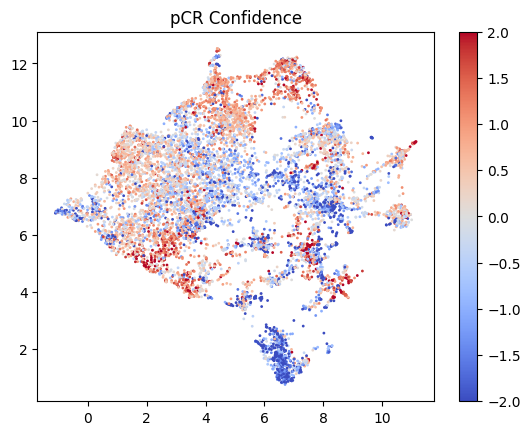

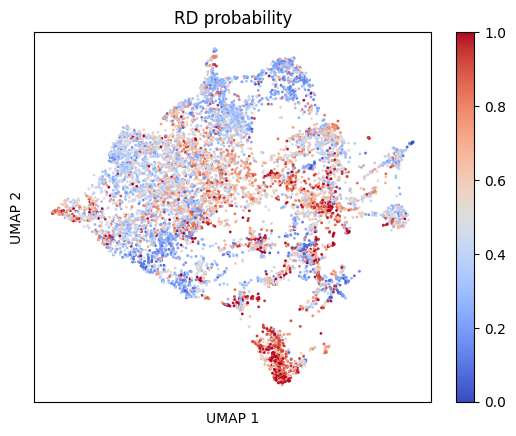

In [19]:
results = umapDF.merge(results[["image_neighborhood","Prediction","Correct","Confidences","Probabilities"]],on="image_neighborhood")
results["Confidence*pCR"] = results["Confidences"]*((results["pCR"]=="pCR")*2-1).astype(int)
plt.scatter(results["UMAP 1"],results["UMAP 2"],c=results["Confidences"],s=1,cmap="coolwarm",vmin=-2,vmax=2)
plt.title("pCR Confidence")
plt.colorbar()
plt.show()
plt.scatter(results["UMAP 1"],results["UMAP 2"],c=results["Probabilities"],s=1,cmap="coolwarm",vmin=0,vmax=1)
plt.title("RD probability")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar()
plt.savefig("RDprobability.pdf")
plt.show()

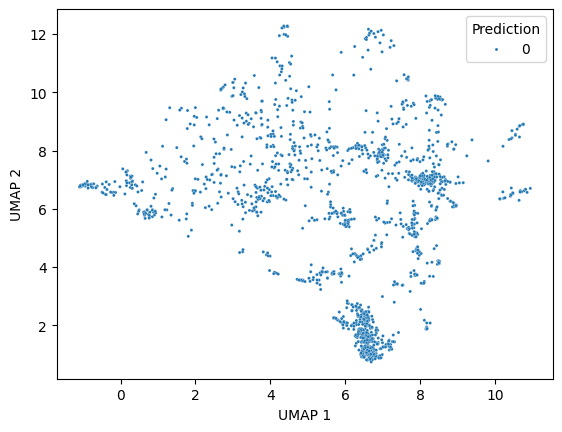

In [20]:
sns.scatterplot(results[(results["Probabilities"]>0.75)&(results["pCR"]=="RD")],x="UMAP 1",y="UMAP 2",hue="Prediction",s=5)
rd_pred = list(results[(results["Probabilities"]>0.75)&(results["pCR"]=="RD")]["image_neighborhood"])
umapDF_RD = umapDF[umapDF["image_neighborhood"].isin(rd_pred)]

In [21]:
import numpy as np
import networkx as nx
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
import leidenalg
import igraph as ig

# dist_matrix = ...  # Your symmetric NxN distance matrix
# Convert distance to similarity (e.g., Gaussian kernel)
dist_matrix = dists.values

sigma = np.median(dist_matrix)
similarity = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
similarity = pd.DataFrame(similarity,index=dists.index,columns=dists.index)

similarity = similarity.loc[umapDF_RD["image_neighborhood"]][umapDF_RD["image_neighborhood"]]
# Convert to graph (thresholding helps)
threshold = 0.9
adj_matrix = (similarity > threshold).astype(float) * similarity

# Convert to igraph
G = ig.Graph.Weighted_Adjacency(adj_matrix, mode='UNDIRECTED')
partition = leidenalg.find_partition(G, leidenalg.RBConfigurationVertexPartition)

# === Step 5: Filter small clusters ===
min_size = 40
labels = np.array([partition.membership[i] for i in range(len(partition.membership))])

# Count members per cluster
from collections import Counter
counts = Counter(labels)

# Relabel: clusters with < min_size → -1
filtered_labels = np.array([
    label if counts[label] >= min_size else -1
    for label in labels
])
set(filtered_labels)

{-1, 0, 1, 2, 3}

/tmp/ipykernel_1923910/3732975970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_RD["cluster"] = filtered_labels
/tmp/ipykernel_1923910/3732975970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_RD["cluster"] = umapDF_RD["cluster"].astype(str)


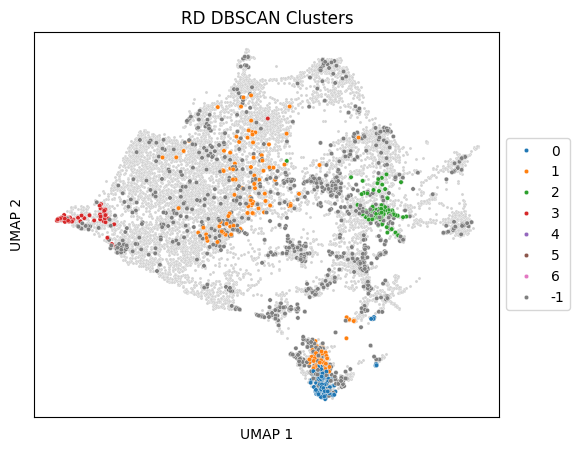

In [22]:
umapDF_RD["cluster"] = filtered_labels
umapDF_RD["cluster"] = umapDF_RD["cluster"].astype(str)
fig =plt.figure(figsize=(6,5))
sns.scatterplot(umapDF, x="UMAP 1", y = "UMAP 2",s=5,c='lightgrey')
sns.scatterplot(umapDF_RD[umapDF_RD["cluster"]!="nan"].sort_values("cluster"), x="UMAP 1", y = "UMAP 2", 
                hue_order=["0","1","2","3","4","5","6","-1"],hue=umapDF_RD["cluster"],s=10,
               palette="tab10")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("RD DBSCAN Clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("RD-DBSCAN-Clusters.pdf",bbox_inches="tight")
plt.show()

In [23]:
import glob
vs = []
for f in glob.glob("/mnt/isilon/tan_lab/xiongb/NOrbitRevision/intermediates/TNBC/CytoCommunity/sampled_vectors/*.csv"):
    v = pd.read_csv(f)
    v = v.set_index("Unnamed: 0")
    v["neighborhood"] = f.split("/")[-1].strip(".csv")
    vs.append(v)
vectors = pd.concat(vs)
vectors = vectors.set_index("neighborhood")

In [24]:
patients = set({})
for c in range(0,4):
    neighborhoods = list(umapDF_RD[(umapDF_RD["cluster"]==str(c))]["image_neighborhood"])
    new = set({})
    for i in neighborhoods:
        patients.add(i.split("_")[0])
        new.add(i.split("_")[0])
    print(len(new),len(neighborhoods))
    rd_vectors = vectors.loc[neighborhoods]
#     rd_vectors[rd_vectors.columns[:37]]/=10
#     rd_vectors[rd_vectors.columns[:37]] = rd_vectors[rd_vectors.columns[:37]].astype(int)
    rd_vectors.to_csv("/mnt/isilon/tan_lab/xiongb/NOrbitRevision/enrichment/TNBC/TNBC-Immuno-CytoREDO-RD-cluster-"+str(c)+".csv")
print(len(patients))

16 180
40 161
18 116
15 58
58


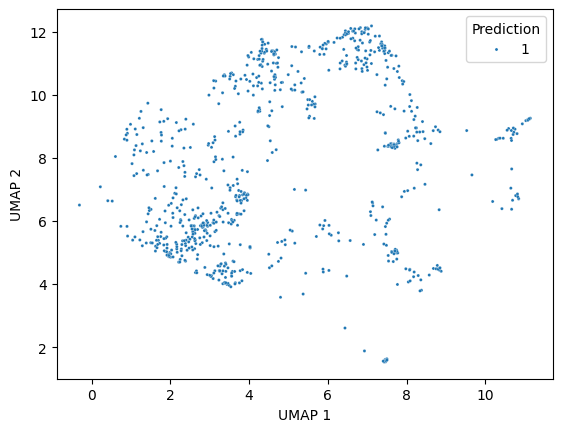

In [25]:
sns.scatterplot(results[(results["Probabilities"]<0.25)&(results["pCR"]=="pCR")],x="UMAP 1",y="UMAP 2",hue="Prediction",s=5)
pcr_pred = list(results[(results["Probabilities"]<0.25)&(results["pCR"]=="pCR")]["image_neighborhood"])
umapDF_pCR = umapDF[umapDF["image_neighborhood"].isin(pcr_pred)]

In [26]:
import numpy as np
import networkx as nx
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
import leidenalg
import igraph as ig

# dist_matrix = ...  # Your symmetric NxN distance matrix
# Convert distance to similarity (e.g., Gaussian kernel)
dist_matrix = dists.values

sigma = np.median(dist_matrix)
similarity = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
similarity = pd.DataFrame(similarity,index=dists.index,columns=dists.index)

similarity = similarity.loc[umapDF_pCR["image_neighborhood"]][umapDF_pCR["image_neighborhood"]]
# Convert to graph (thresholding helps)
threshold = 0.9
adj_matrix = (similarity > threshold).astype(float) * similarity

# Convert to igraph
G = ig.Graph.Weighted_Adjacency(adj_matrix, mode='UNDIRECTED')
partition = leidenalg.find_partition(G, leidenalg.RBConfigurationVertexPartition)

# === Step 5: Filter small clusters ===
min_size = 40
labels = np.array([partition.membership[i] for i in range(len(partition.membership))])

# Count members per cluster
from collections import Counter
counts = Counter(labels)

# Relabel: clusters with < min_size → -1
filtered_labels = np.array([
    label if counts[label] >= min_size else -1
    for label in labels
])
set(filtered_labels)

{-1, 0, 1, 2}

/tmp/ipykernel_1923910/3491973291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_pCR["cluster"] = filtered_labels
/tmp/ipykernel_1923910/3491973291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_pCR["cluster"] = umapDF_pCR["cluster"].astype(str)


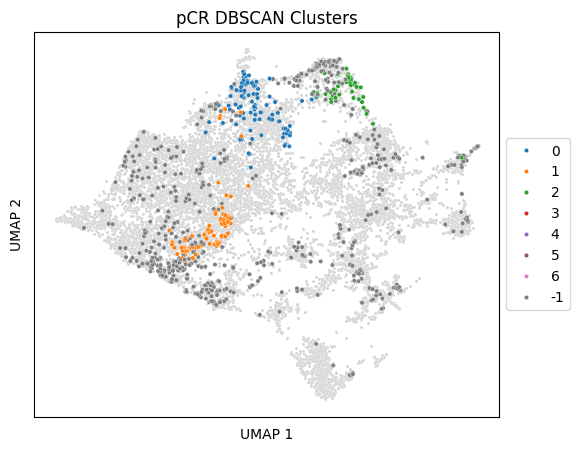

In [27]:
umapDF_pCR["cluster"] = filtered_labels

umapDF_pCR["cluster"] = umapDF_pCR["cluster"].astype(str)
fig =plt.figure(figsize=(6,5))
sns.scatterplot(umapDF, x="UMAP 1", y = "UMAP 2",s=5,c='lightgrey')
sns.scatterplot(umapDF_pCR[umapDF_pCR["cluster"]!="nan"].sort_values("cluster"), x="UMAP 1", y = "UMAP 2", 
                hue_order=["0","1","2","3","4","5","6","-1"],hue=umapDF_pCR["cluster"],s=10,
               palette="tab10")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("pCR DBSCAN Clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("pCR-DBSCAN-Clusters.pdf",bbox_inches="tight")
plt.show()

In [28]:
umapDF_RD["Cluster"] = "RD" + " " + umapDF_RD["cluster"]
umapDF_pCR["Cluster"] = "pCR" + " " + umapDF_pCR["cluster"]
combined = pd.concat([umapDF_RD,umapDF_pCR])
umapDF_clusters = umapDF.merge(combined[["image_neighborhood","Cluster"]],on="image_neighborhood",how="left")
umapDF_clusters["Cluster"] = umapDF_clusters["Cluster"].replace({"RD -1":"other","pCR -1":"other"})
umapDF_clusters["Cluster"] = umapDF_clusters["Cluster"].fillna("other")
umapDF_clusters

/tmp/ipykernel_1923910/1906484777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_RD["Cluster"] = "RD" + " " + umapDF_RD["cluster"]
/tmp/ipykernel_1923910/1906484777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_pCR["Cluster"] = "pCR" + " " + umapDF_pCR["cluster"]


,image_neighborhood,UMAP 1,UMAP 2,PatientID,Phase,Image,pCR,Arm,Phase_pCR,Percent,...,PD-L1^+IDO^+APCs,PD-L1^{+}GZMB^{+},PD-L1^{+}IDO^{+},PDPN^+Stromal,TCF1^{+},Treg,Vimentin^{+}EMT,pH2AX^{+}DSB,panCK^{med},Cluster
0,NT001_Baseline_1460_1,8.804767,6.261047,NT001,Baseline,NT001_Baseline_1460,RD,C&I,Baseline_RD,0.025026,...,0.0,0.000000,0.0,0.000000,0.102041,0.00000,0.571429,0.040816,0.142857,RD 2
1,NT001_Baseline_1460_2,8.915257,6.122697,NT001,Baseline,NT001_Baseline_1460,RD,C&I,Baseline_RD,0.443820,...,0.0,0.001151,0.0,0.000000,0.051784,0.00000,0.620253,0.032221,0.008055,other
2,NT001_Baseline_1460_3,8.874290,6.207644,NT001,Baseline,NT001_Baseline_1460,RD,C&I,Baseline_RD,0.109806,...,0.0,0.004651,0.0,0.000000,0.051163,0.00000,0.516279,0.153488,0.037209,other
3,NT001_Baseline_1460_4,8.829028,6.256142,NT001,Baseline,NT001_Baseline_1460,RD,C&I,Baseline_RD,0.083759,...,0.0,0.000000,0.0,0.000000,0.048780,0.00000,0.640244,0.109756,0.121951,RD 2
4,NT001_Baseline_1460_5,8.936669,6.120098,NT001,Baseline,NT001_Baseline_1460,RD,C&I,Baseline_RD,0.209397,...,0.0,0.002439,0.0,0.000000,0.053659,0.00000,0.395122,0.324390,0.068293,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11866,NT279_Post-treatment_422_8,4.042274,8.060930,NT279,Post-treatment,NT279_Post-treatment_422,RD,C&I,Post-treatment_RD,0.473770,...,0.0,0.000000,0.0,0.027682,0.000000,0.00346,0.000000,0.000000,0.000000,other
11867,NT279_Post-treatment_425_4,4.953689,9.677067,NT279,Post-treatment,NT279_Post-treatment_425,RD,C&I,Post-treatment_RD,0.413333,...,0.0,0.000000,0.0,0.004608,0.000000,0.00000,0.000000,0.000000,0.000000,other
11868,NT279_Post-treatment_425_5,4.759151,9.744830,NT279,Post-treatment,NT279_Post-treatment_425,RD,C&I,Post-treatment_RD,0.205714,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,other
11869,NT279_Post-treatment_425_6,3.327219,9.763407,NT279,Post-treatment,NT279_Post-treatment_425,RD,C&I,Post-treatment_RD,0.112381,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,other


In [29]:
umapDF_clusters.to_csv("TNBC-Immuno-important-clusters.csv")

In [30]:
patients = set({})
for c in range(0,3):
    neighborhoods = list(umapDF_pCR[(umapDF_pCR["cluster"]==str(c))]["image_neighborhood"])
    new = set({})
    for i in neighborhoods:
        patients.add(i.split("_")[0])
        new.add(i.split("_")[0])
    print(len(new),len(neighborhoods))
    pcr_vectors = vectors.loc[neighborhoods]
    pcr_vectors.to_csv("/mnt/isilon/tan_lab/xiongb/NOrbitRevision/enrichment/TNBC/TNBC-Immuno-CytoREDO-pCR-cluster-"+str(c)+".csv")
print(len(patients))

47 106
28 85
28 47
68


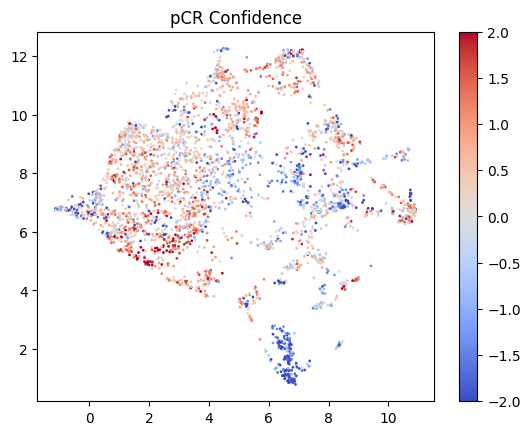

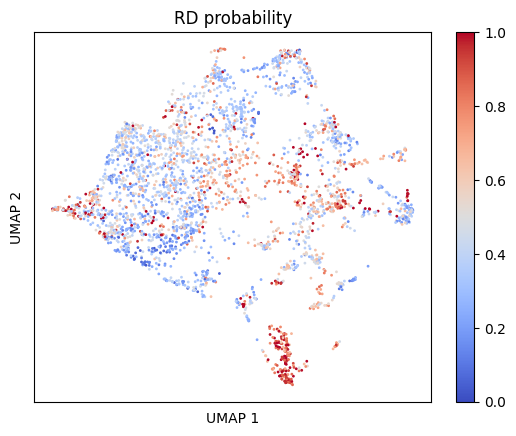

In [31]:
test_results = umapDF.merge(test_results[["image_neighborhood","Prediction","Correct","Confidences","Probabilities"]],on="image_neighborhood")
test_results["Confidence*pCR"] = test_results["Confidences"]*((results["pCR"]=="pCR")*2-1).astype(int)
plt.scatter(test_results["UMAP 1"],test_results["UMAP 2"],c=test_results["Confidences"],s=1,cmap="coolwarm",vmin=-2,vmax=2)
plt.title("pCR Confidence")
plt.colorbar()
plt.show()
plt.scatter(test_results["UMAP 1"],test_results["UMAP 2"],c=test_results["Probabilities"],s=1,cmap="coolwarm",vmin=0,vmax=1)
plt.title("RD probability")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar()
plt.savefig("RDprobability.pdf")
plt.show()

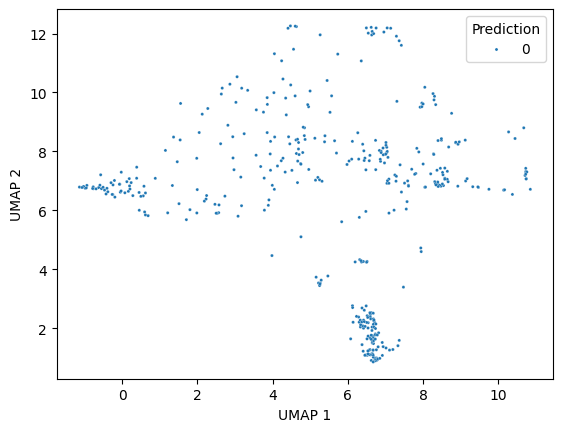

In [32]:
sns.scatterplot(test_results[(test_results["Probabilities"]>0.75)&(test_results["pCR"]=="RD")],x="UMAP 1",y="UMAP 2",hue="Prediction",s=5)
rd_pred_test = list(test_results[(test_results["Probabilities"]>0.75)&(test_results["pCR"]=="RD")]["image_neighborhood"])
umapDF_RD_test = umapDF[umapDF["image_neighborhood"].isin(rd_pred_test)]

In [33]:
# dist_matrix = ...  # Your symmetric NxN distance matrix
# Convert distance to similarity (e.g., Gaussian kernel)
dist_matrix = dists.values

sigma = np.median(dist_matrix)
similarity = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
similarity = pd.DataFrame(similarity,index=dists.index,columns=dists.index)

similarity = similarity.loc[umapDF_RD_test["image_neighborhood"]][umapDF_RD_test["image_neighborhood"]]
# Convert to graph (thresholding helps)
threshold = 0.85
adj_matrix = (similarity > threshold).astype(float) * similarity

# Convert to igraph
G = ig.Graph.Weighted_Adjacency(adj_matrix, mode='UNDIRECTED')
partition = leidenalg.find_partition(G, leidenalg.RBConfigurationVertexPartition)

# === Step 5: Filter small clusters ===
min_size = 35
labels = np.array([partition.membership[i] for i in range(len(partition.membership))])

# Count members per cluster
from collections import Counter
counts = Counter(labels)

# Relabel: clusters with < min_size → -1
filtered_labels = np.array([
    label if counts[label] >= min_size else -1
    for label in labels
])
set(filtered_labels)

{-1, 0, 1, 2, 3}

/tmp/ipykernel_1923910/2889897748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_RD_test["cluster"]=filtered_labels
/tmp/ipykernel_1923910/2889897748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_RD_test["cluster"] = umapDF_RD_test["cluster"].map({0:1,1:0,2:2,3:3,-1:-1}).astype(int).astype(str)


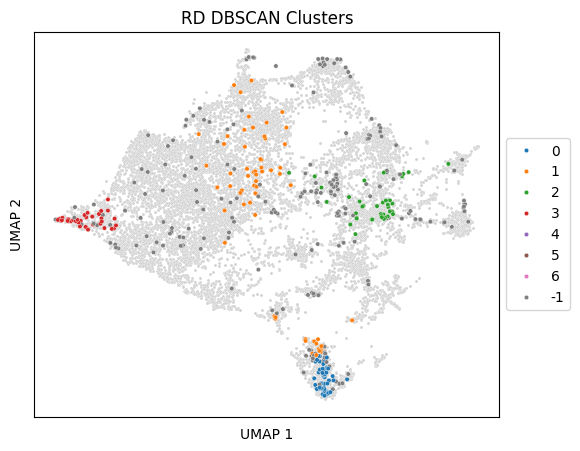

In [34]:
umapDF_RD_test["cluster"]=filtered_labels
umapDF_RD_test["cluster"] = umapDF_RD_test["cluster"].map({0:1,1:0,2:2,3:3,-1:-1}).astype(int).astype(str)
fig =plt.figure(figsize=(6,5))
sns.scatterplot(umapDF, x="UMAP 1", y = "UMAP 2",s=5,c='lightgrey')
sns.scatterplot(umapDF_RD_test[umapDF_RD_test["cluster"]!="nan"].sort_values("cluster"), x="UMAP 1", y = "UMAP 2", 
                hue_order=["0","1","2","3","4","5","6","-1"],hue=umapDF_RD_test["cluster"],s=10,
               palette="tab10")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("RD DBSCAN Clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("RD-DBSCAN-Clusters_test.pdf",bbox_inches="tight")
plt.show()

In [35]:
patients = set({})
for c in range(0,4):
    neighborhoods = list(umapDF_RD_test[(umapDF_RD_test["cluster"]==str(c))]["image_neighborhood"])
    new = set({})
    for i in neighborhoods:
        patients.add(i.split("_")[0])
        new.add(i.split("_")[0])
    print(len(new),len(neighborhoods))
    rd_vectors = vectors.loc[neighborhoods]
#     rd_vectors[rd_vectors.columns[:37]]/=10
#     rd_vectors[rd_vectors.columns[:37]] = rd_vectors[rd_vectors.columns[:37]].astype(int)
    rd_vectors.to_csv("/mnt/isilon/tan_lab/xiongb/NOrbitRevision/enrichment/TNBC/TNBC-Immuno-CytoREDO-RD-cluster-test-"+str(c)+".csv")
print(len(patients))

6 60
16 65
8 40
7 36
22


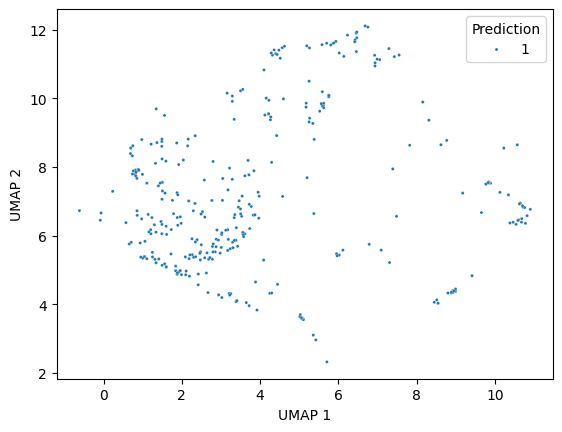

In [36]:
sns.scatterplot(test_results[(test_results["Probabilities"]<0.25)&(test_results["pCR"]=="pCR")],x="UMAP 1",y="UMAP 2",hue="Prediction",s=5)
pcr_pred_test = list(test_results[(test_results["Probabilities"]<0.25)&(test_results["pCR"]=="pCR")]["image_neighborhood"])
umapDF_pCR_test = umapDF[umapDF["image_neighborhood"].isin(pcr_pred_test)]

In [37]:
# dist_matrix = ...  # Your symmetric NxN distance matrix
# Convert distance to similarity (e.g., Gaussian kernel)
dist_matrix = dists.values

sigma = np.median(dist_matrix)
similarity = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))
similarity = pd.DataFrame(similarity,index=dists.index,columns=dists.index)

similarity = similarity.loc[umapDF_pCR_test["image_neighborhood"]][umapDF_pCR_test["image_neighborhood"]]
# Convert to graph (thresholding helps)
threshold = 0.85
adj_matrix = (similarity > threshold).astype(float) * similarity

# Convert to igraph
G = ig.Graph.Weighted_Adjacency(adj_matrix, mode='UNDIRECTED')
partition = leidenalg.find_partition(G, leidenalg.RBConfigurationVertexPartition)

# === Step 5: Filter small clusters ===
min_size = 20
labels = np.array([partition.membership[i] for i in range(len(partition.membership))])

# Count members per cluster
from collections import Counter
counts = Counter(labels)

# Relabel: clusters with < min_size → -1
filtered_labels = np.array([
    label if counts[label] >= min_size else -1
    for label in labels
])
set(filtered_labels)

{-1, 0, 1, 2, 3}

/tmp/ipykernel_1923910/1825849663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_pCR_test["cluster"]=filtered_labels
/tmp/ipykernel_1923910/1825849663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_pCR_test["cluster"] = umapDF_pCR_test["cluster"].map({1:0,0:1,3:2,2:-1,-1:-1}).astype(int).astype(str)


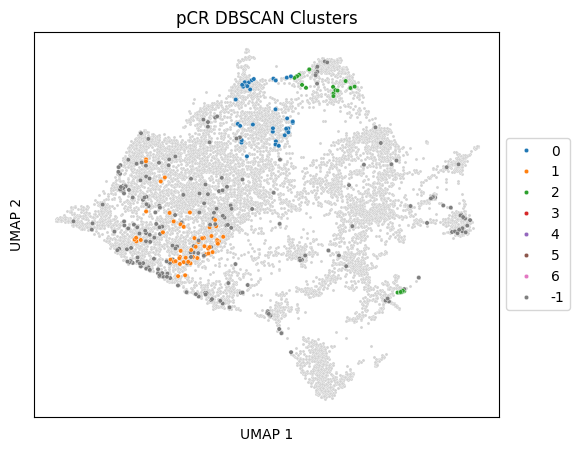

In [40]:
umapDF_pCR_test["cluster"]=filtered_labels
umapDF_pCR_test["cluster"] = umapDF_pCR_test["cluster"].map({1:0,0:1,3:2,2:-1,-1:-1}).astype(int).astype(str)

fig =plt.figure(figsize=(6,5))
sns.scatterplot(umapDF, x="UMAP 1", y = "UMAP 2",s=5,c='lightgrey')
sns.scatterplot(umapDF_pCR_test[umapDF_pCR_test["cluster"]!="nan"].sort_values("cluster"), x="UMAP 1", y = "UMAP 2", 
                hue_order=["0","1","2","3","4","5","6","-1"],hue=umapDF_pCR_test["cluster"],s=10,
               palette="tab10")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("pCR DBSCAN Clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("pCR-DBSCAN-Clusters-test.pdf",bbox_inches="tight")
plt.show()

In [41]:
umapDF_RD_test["Cluster"] = "RD" + " " + umapDF_RD_test["cluster"] + " test"
umapDF_pCR_test["Cluster"] = "pCR" + " " + umapDF_pCR_test["cluster"] + " test"
combined = pd.concat([umapDF_RD_test,umapDF_pCR_test])
umapDF_clusters_test = umapDF.merge(combined[["image_neighborhood","Cluster"]],on="image_neighborhood",how="left")
umapDF_clusters_test["Cluster"] = umapDF_clusters_test["Cluster"].replace({"RD -1 test":"other","pCR -1 test":"other"})
umapDF_clusters_test["Cluster"] = umapDF_clusters_test["Cluster"].fillna("other")
umapDF_clusters_test.to_csv("TNBC-Immuno-important-clusters-test.csv")

/tmp/ipykernel_1923910/439238250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_RD_test["Cluster"] = "RD" + " " + umapDF_RD_test["cluster"] + " test"
/tmp/ipykernel_1923910/439238250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umapDF_pCR_test["Cluster"] = "pCR" + " " + umapDF_pCR_test["cluster"] + " test"


In [42]:
patients = set({})
for c in range(0,3):
    neighborhoods = list(umapDF_pCR_test[(umapDF_pCR_test["cluster"]==str(c))]["image_neighborhood"])
    new = set({})
    for i in neighborhoods:
        patients.add(i.split("_")[0])
        new.add(i.split("_")[0])
    print(len(new),len(neighborhoods))
    rd_vectors = vectors.loc[neighborhoods]
#     rd_vectors[rd_vectors.columns[:37]]/=10
#     rd_vectors[rd_vectors.columns[:37]] = rd_vectors[rd_vectors.columns[:37]].astype(int)
    rd_vectors.to_csv("/mnt/isilon/tan_lab/xiongb/NOrbitRevision/enrichment/TNBC/TNBC-Immuno-CytoREDO-pCR-cluster-test-"+str(c)+".csv")
print(len(patients))

15 38
14 51
8 21
23


In [43]:
from scipy import stats
data = data.sort_values("Image")
ranks = []
for image in sorted(set(data["Image"])):
    data_im = data[data["Image"]==image]
    new_ranks = stats.rankdata(list(-data_im["Percent"]))
    ranks.extend(new_ranks)
data["Rank"] = ranks
data["Rank"] = data["Rank"].astype(int)

In [44]:
neighborhood_features = neighborhood_latent.set_index("image_neighborhood")[sigvars]

imageList = sorted(set(neighborhood_latent["Image"]))

im_columns = []
for index, row in sigvarsDF.iterrows():
    for i in range(11):
        im_columns.append("TCN " + str(i) + " " + row["Name"])
imageDF = pd.DataFrame(index=imageList,columns=im_columns)

for image in imageList:
    print(image)
    for tcn in range(11):
        if (image + "_") + str(tcn) in neighborhood_features.index:
            rank = data.loc[(image + "_") + str(tcn)]["Rank"]
            for feature in neighborhood_features.columns:
                imageDF.loc[image,"TCN " + str(rank) + " " + feature] = neighborhood_features.loc[(image + "_") + str(tcn),feature]

imageDF = imageDF.dropna(axis=1, how="all")
im_columns = imageDF.columns

NT001_Baseline_1460
NT001_Baseline_1461
NT001_Baseline_1462
NT001_On-treatment_1463
NT001_On-treatment_1464
NT001_On-treatment_1465
NT001_Post-treatment_469
NT001_Post-treatment_477
NT002_Baseline_659
NT002_Baseline_660
NT002_Baseline_661
NT002_On-treatment_662
NT002_On-treatment_663
NT002_On-treatment_664
NT003_Baseline_1325
NT003_Baseline_1326
NT003_Baseline_1327
NT003_On-treatment_1328
NT003_On-treatment_1329
NT003_On-treatment_1330
NT003_Post-treatment_408
NT003_Post-treatment_412
NT004_Baseline_1438
NT004_Baseline_1439
NT004_Baseline_1440
NT004_On-treatment_1441
NT004_On-treatment_1442
NT004_On-treatment_1443
NT005_Baseline_1384
NT005_Baseline_1385
NT005_Baseline_1386
NT005_Post-treatment_439
NT005_Post-treatment_442
NT006_Post-treatment_94
NT007_Baseline_1821
NT007_Baseline_1822
NT007_Baseline_1823
NT007_Post-treatment_556
NT008_Baseline_1042
NT008_Baseline_1043
NT008_Baseline_1044
NT008_On-treatment_1
NT008_On-treatment_10
NT008_On-treatment_2
NT008_On-treatment_3
NT008_On-treat

NT057_Baseline_707
NT057_Baseline_708
NT057_On-treatment_709
NT057_On-treatment_710
NT057_On-treatment_711
NT058_Baseline_1150
NT058_Baseline_1151
NT058_Baseline_1152
NT058_Post-treatment_302
NT059_On-treatment_1322
NT059_On-treatment_1323
NT059_On-treatment_1324
NT059_Post-treatment_394
NT059_Post-treatment_400
NT060_Baseline_1051
NT060_Baseline_1052
NT060_Baseline_1053
NT060_On-treatment_1054
NT060_On-treatment_1055
NT060_Post-treatment_269
NT060_Post-treatment_275
NT060_Post-treatment_281
NT061_Baseline_1812
NT061_Baseline_1813
NT061_Baseline_1814
NT061_On-treatment_1815
NT061_On-treatment_1816
NT061_On-treatment_1817
NT062_Baseline_1083
NT062_Baseline_1084
NT062_Baseline_1085
NT062_On-treatment_1086
NT062_On-treatment_1087
NT062_On-treatment_1088
NT062_Post-treatment_322
NT062_Post-treatment_327
NT062_Post-treatment_331
NT063_Baseline_1282
NT063_Baseline_1283
NT063_Baseline_1284
NT063_On-treatment_1285
NT063_On-treatment_1286
NT063_Post-treatment_393
NT063_Post-treatment_397
NT063_

NT113_Post-treatment_133
NT113_Post-treatment_139
NT114_Baseline_898
NT114_Baseline_899
NT114_Baseline_900
NT114_On-treatment_901
NT114_On-treatment_902
NT114_Post-treatment_235
NT114_Post-treatment_241
NT114_Post-treatment_247
NT115_Baseline_1497
NT115_Baseline_1498
NT115_Baseline_1499
NT115_On-treatment_1500
NT115_On-treatment_1501
NT115_On-treatment_1502
NT115_Post-treatment_460
NT115_Post-treatment_463
NT115_Post-treatment_467
NT116_Baseline_761
NT116_Baseline_762
NT116_Baseline_763
NT116_Post-treatment_131
NT116_Post-treatment_137
NT116_Post-treatment_143
NT117_Baseline_1842
NT117_Baseline_1843
NT117_Baseline_1844
NT118_Baseline_966
NT118_Baseline_967
NT118_Baseline_968
NT119_Baseline_1475
NT119_Baseline_1476
NT119_Baseline_1477
NT119_On-treatment_1478
NT120_On-treatment_609
NT120_On-treatment_610
NT120_On-treatment_611
NT121_Baseline_770
NT121_Baseline_771
NT121_Baseline_772
NT121_On-treatment_773
NT121_On-treatment_774
NT121_On-treatment_775
NT121_Post-treatment_148
NT121_Post-t

NT176_Baseline_801
NT176_Baseline_802
NT176_On-treatment_803
NT176_On-treatment_804
NT176_On-treatment_805
NT176_Post-treatment_198
NT176_Post-treatment_204
NT177_Baseline_951
NT177_Baseline_952
NT177_Baseline_953
NT177_Post-treatment_212
NT178_Baseline_718
NT178_Baseline_719
NT178_Baseline_720
NT178_On-treatment_721
NT178_On-treatment_722
NT178_On-treatment_723
NT178_Post-treatment_129
NT178_Post-treatment_135
NT178_Post-treatment_141
NT179_Baseline_694
NT179_Baseline_695
NT179_Baseline_696
NT179_On-treatment_697
NT179_On-treatment_698
NT179_On-treatment_699
NT179_Post-treatment_128
NT179_Post-treatment_134
NT179_Post-treatment_140
NT180_Baseline_625
NT180_Baseline_626
NT180_Baseline_628
NT180_On-treatment_629
NT180_On-treatment_630
NT180_On-treatment_631
NT180_Post-treatment_106
NT180_Post-treatment_111
NT181_Baseline_954
NT181_Baseline_955
NT181_Baseline_956
NT181_On-treatment_957
NT181_On-treatment_958
NT181_On-treatment_959
NT181_Post-treatment_222
NT181_Post-treatment_227
NT181_P

NT228_On-treatment_1001
NT228_On-treatment_999
NT228_Post-treatment_252
NT228_Post-treatment_256
NT228_Post-treatment_260
NT229_Post-treatment_513
NT230_Baseline_737
NT230_Baseline_738
NT230_Baseline_739
NT230_On-treatment_740
NT230_On-treatment_741
NT230_On-treatment_742
NT230_Post-treatment_115
NT230_Post-treatment_120
NT230_Post-treatment_124
NT231_Baseline_824
NT231_Baseline_825
NT231_Baseline_826
NT231_On-treatment_827
NT231_On-treatment_828
NT231_On-treatment_829
NT231_Post-treatment_194
NT231_Post-treatment_200
NT231_Post-treatment_206
NT232_Baseline_1002
NT232_Baseline_1003
NT232_Baseline_1004
NT232_On-treatment_1005
NT232_On-treatment_1006
NT232_On-treatment_1007
NT232_Post-treatment_266
NT232_Post-treatment_272
NT232_Post-treatment_278
NT233_On-treatment_1803
NT233_On-treatment_1804
NT233_On-treatment_1805
NT234_Post-treatment_164
NT234_Post-treatment_169
NT234_Post-treatment_174
NT235_Baseline_1417
NT235_Baseline_1418
NT235_Baseline_1419
NT235_Post-treatment_437
NT236_Baseli

In [45]:
imageDF["PatientID"] = [i.split("_")[0] for i in imageDF.index]
imageDF["Phase"] = [i.split("_")[1] for i in imageDF.index]
imageDF["Image"] = imageDF.index

imageDF = imageDF.merge(clinical,on="PatientID")
imageDF = imageDF.set_index("Image")
imageDF["pCRbin"] = [int(i=="pCR") for i in imageDF["pCR"]]

/tmp/ipykernel_1923910/3036831035.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  imageDF["pCRbin"] = [int(i=="pCR") for i in imageDF["pCR"]]


In [46]:
# Make splits by patient
# patient_splits = [i[1][1] for i in enumerate(KFold(n_splits=15, shuffle=True, random_state=42).split(range(279)))]
splits = []
# Train and validation rolling splits
for i in patient_splits[:-1]:
    indices = []
    for p in i:
        ind = [index for index,value in enumerate(imageDF.index) if clinical.iloc[p]["PatientID"] in value]
        indices.extend(ind)
    notIndices = [i for i in range(len(imageDF.index)) if i not in indices]
    splits.append((notIndices,indices))
    
# Test split
test_split = []
for i in patient_splits[-1:]:
    indices = []
    for p in i:
        ind = [index for index,value in enumerate(imageDF.index) if clinical.iloc[p]["PatientID"] in value]
        indices.extend(ind)
    notIndices = [i for i in range(len(imageDF.index)) if i not in indices]
    test_split.append((notIndices,indices))
    

In [47]:
from sklearn.impute import SimpleImputer
# imputed= SimpleImputer().fit_transform(imageDF[im_columns])

scaler = StandardScaler()
scaled = scaler.fit_transform(imageDF[im_columns])
scaled = SimpleImputer(strategy="median").fit_transform(scaled)
scores = []
coefs = []
results = {"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[]}
for (train_index, test_index) in splits:
    clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                             max_iter=10000)
    clf.fit(scaled[train_index],np.array(imageDF["pCRbin"])[train_index])
    predictions = clf.predict(scaled[test_index])
    confidences = clf.decision_function(scaled[test_index])
    probabilities = clf.predict_proba(scaled[test_index])
    for i in range(len(test_index)):
        results["Prediction"].append(predictions[i])
        results["Actual"].append(imageDF.iloc[test_index[i]]["pCRbin"])
        results["Correct"].append(int(predictions[i]==imageDF.iloc[test_index[i]]["pCRbin"]))
        results["Phase"].append(imageDF.iloc[test_index[i]]["Phase"])
        results["Patient"].append(imageDF.iloc[test_index[i]]["PatientID"])
        results["Image"].append(imageDF.iloc[test_index[i]].index)
        results["Confidences"].append(confidences[i])
        results["Probabilities"].append(probabilities[i][0])
    print(np.mean(results["Correct"]))
    coefs.append(clf.coef_)

results = pd.DataFrame(results)
print(results.groupby("Phase")["Correct"].mean())
print(results["Correct"].mean())

0.6872246696035242
0.6534653465346535
0.6508279337652988
Phase
Baseline          0.627660
On-treatment      0.666667
Post-treatment    0.666667
Name: Correct, dtype: float64
0.6508279337652988


In [48]:
coefDF = pd.DataFrame({"Features":im_columns, "Mean Coef":np.mean(coefs,axis=0)[0], "SD Coef": np.std(coefs,axis=0)[0]})
coefDF["Abs Coef"] = np.abs(coefDF["Mean Coef"])
coefDF = coefDF.sort_values("Abs Coef",ascending=False)
coefDF["Std Error Coef"] = coefDF["SD Coef"]/math.sqrt(15)
coefDF["Z"] = coefDF["Mean Coef"]/coefDF["Std Error Coef"] 
coefDF["Abs Z"] = np.abs(coefDF["Z"])
coefDF["p_values"] = 2 * (1 - norm.cdf(np.abs(coefDF["Z"])))
coefDF["bonferroni_p"] = multipletests(coefDF["p_values"], method="bonferroni")[1]
coefDF = coefDF.sort_values("Abs Z", ascending=False)
sigvars = list(coefDF[(coefDF["Abs Coef"] > 0.075)&(coefDF["bonferroni_p"]<0.05)]['Features'])
coefDF[(coefDF["Abs Coef"]>0.075)&(coefDF["bonferroni_p"]<0.05)]

,Features,Mean Coef,SD Coef,Abs Coef,Std Error Coef,Z,Abs Z,p_values,bonferroni_p
486,TCN 7 On-treatment*Neutrophils,-0.108075,0.002996,0.108075,0.000773,-139.722475,139.722475,0.000000,0.000000
376,TCN 7 Post-treatment*7,0.269339,0.018849,0.269339,0.004867,55.342429,55.342429,0.000000,0.000000
882,TCN 3 Post-treatment*0,0.429666,0.033842,0.429666,0.008738,49.172210,49.172210,0.000000,0.000000
7,TCN 8 Baseline*CK^{lo}GATA3^{+} Ki67,0.698812,0.058440,0.698812,0.015089,46.312213,46.312213,0.000000,0.000000
345,TCN 6 On-treatment*Treg Ki67,-0.565660,0.048312,0.565660,0.012474,-45.346387,45.346387,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
516,TCN 7 On-treatment*8,-0.130949,0.123032,0.130949,0.031767,-4.122229,4.122229,0.000038,0.033395
126,TCN 7 On-treatment*CK^{hi}GATA3^{+},0.107032,0.100662,0.107032,0.025991,4.118067,4.118067,0.000038,0.034004
687,TCN 8 Post-treatment*3,-0.238842,0.226442,0.238842,0.058467,-4.085065,4.085065,0.000044,0.039217
400,TCN 1 Post-treatment*CA9^+,-0.176787,0.168620,0.176787,0.043537,-4.060570,4.060570,0.000049,0.043568


In [49]:
from sklearn.impute import SimpleImputer

scaler = StandardScaler()
scaled = scaler.fit_transform(imageDF[sigvars])
scaled = SimpleImputer(strategy="median").fit_transform(scaled)

scores = []
coefs = []
results = {"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[], "Arm":[]}
for (train_index, test_index) in splits:
    clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                             max_iter=10000)
    clf.fit(scaled[train_index],np.array(imageDF["pCRbin"])[train_index])
    predictions = clf.predict(scaled[test_index])
    confidences = clf.decision_function(scaled[test_index])
    probabilities = clf.predict_proba(scaled[test_index])
    for i in range(len(test_index)):
        results["Prediction"].append(predictions[i])
        results["Actual"].append(imageDF.iloc[test_index[i]]["pCRbin"])
        results["Correct"].append(int(predictions[i]==imageDF.iloc[test_index[i]]["pCRbin"]))
        results["Phase"].append(imageDF.iloc[test_index[i]]["Phase"])
        results["Patient"].append(imageDF.iloc[test_index[i]]["PatientID"])
        results["Image"].append(imageDF.iloc[test_index[i]].index[0])
        results["Confidences"].append(confidences[i])
        results["Probabilities"].append(probabilities[i][0])
        results["Arm"].append(imageDF.iloc[test_index[i]]["Arm"])
    print(np.mean(results["Correct"]))
    coefs.append(clf.coef_)

results = pd.DataFrame(results)
print(results.groupby("Phase")["Correct"].mean())
print(results["Correct"].mean())

0.748898678414097
0.7161716171617162
0.720662347012239
Phase
Baseline          0.703901
On-treatment      0.738562
Post-treatment    0.724044
Name: Correct, dtype: float64
0.720662347012239


In [50]:
test_results = {"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[],"Arm":[]}
for (train_index, test_index) in test_split:
    clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                             max_iter=10000)
    clf.fit(scaled[train_index],np.array(imageDF["pCRbin"])[train_index])
    test_predictions = clf.predict(scaled[test_index])
    test_confidences = clf.decision_function(scaled[test_index])
    test_probabilities = clf.predict_proba(scaled[test_index])
    for i in range(len(test_index)):
        test_results["Prediction"].append(test_predictions[i])
        test_results["Actual"].append(imageDF.iloc[test_index[i]]["pCRbin"])
        test_results["Correct"].append(int(test_predictions[i]==imageDF.iloc[test_index[i]]["pCRbin"]))
        test_results["Phase"].append(imageDF.iloc[test_index[i]]["Phase"])
        test_results["Patient"].append(imageDF.iloc[test_index[i]]["PatientID"])
        test_results["Image"].append(imageDF.iloc[test_index[i]].index[0])
        test_results["Confidences"].append(test_confidences[i])
        test_results["Probabilities"].append(test_probabilities[i][0])
        test_results["Arm"].append(imageDF.iloc[test_index[i]]["Arm"])

    print(clf.score(scaled[test_index],imageDF.iloc[test_index]["pCRbin"]))
test_results = pd.DataFrame(test_results)
print(test_results.groupby("Phase")["Correct"].mean())
print(test_results["Correct"].mean())

0.7424892703862661
Phase
Baseline          0.717822
On-treatment      0.710692
Post-treatment    0.838095
Name: Correct, dtype: float64
0.7424892703862661


In [51]:
grouped = pd.DataFrame(results.groupby(["Actual","Patient","Phase","Arm"])["Confidences"].mean()).reset_index()
grouped = grouped[grouped["Phase"].isin(["Baseline"])]
grouped = pd.DataFrame(grouped.groupby(["Actual","Patient","Arm"])["Confidences"].mean()).reset_index()

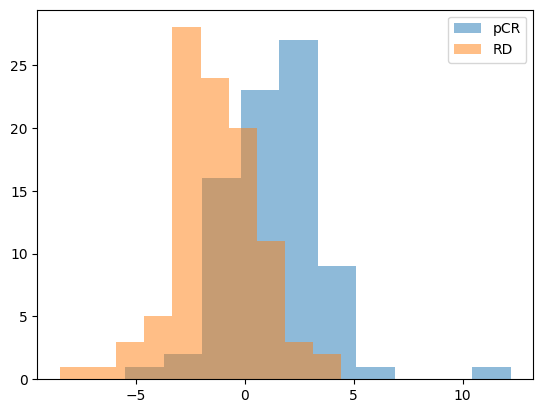

In [52]:
plt.hist(grouped[grouped["Actual"]==1]["Confidences"],alpha=0.5,label="pCR")
plt.hist(grouped[grouped["Actual"]==0]["Confidences"],alpha=0.5,label="RD")
plt.legend()

In [53]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(roc_auc_score(grouped["Actual"],grouped["Confidences"]))
best_accuracy = 0
best_threshold = 0
for i in np.arange(-5,5,0.01):
    acc = accuracy_score(grouped["Actual"],(grouped["Confidences"]>i))
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = i
print(best_accuracy, best_threshold)

best_accuracy_ci = 0
best_threshold_ci = 0
for i in np.arange(-5,5,0.01):
    acc = accuracy_score(grouped[grouped["Arm"]=="C&I"]["Actual"],(grouped[grouped["Arm"]=="C&I"]["Confidences"]>i))
    if acc > best_accuracy_ci:
        best_accuracy_ci = acc
        best_threshold_ci = i
print(best_accuracy_ci, best_threshold_ci)

best_accuracy_c = 0
best_threshold_c = 0
for i in np.arange(-5,5,0.01):
    acc = accuracy_score(grouped[grouped["Arm"]=="C"]["Actual"],(grouped[grouped["Arm"]=="C"]["Confidences"]>i))
    if acc > best_accuracy_c:
        best_accuracy_c = acc
        best_threshold_c = i
print(best_accuracy_c, best_threshold_c)

0.8385204081632653
0.7752808988764045 -0.5800000000000942
0.8222222222222222 -0.2800000000001006
0.75 -0.5800000000000942


In [54]:
test_grouped = pd.DataFrame(test_results.groupby(["Actual","Patient","Phase","Arm"])["Confidences"].mean()).reset_index()
test_grouped = test_grouped[test_grouped["Phase"].isin(["Baseline"])]
test_grouped = pd.DataFrame(test_grouped.groupby(["Actual","Patient","Arm"])["Confidences"].mean()).reset_index()

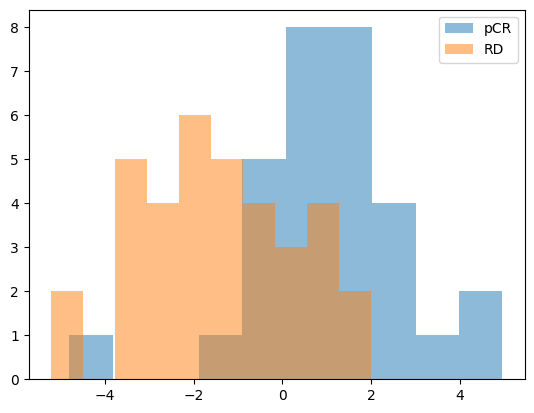

In [55]:
plt.hist(test_grouped[test_grouped["Actual"]==1]["Confidences"],alpha=0.5,label="pCR")
plt.hist(test_grouped[test_grouped["Actual"]==0]["Confidences"],alpha=0.5,label="RD")
plt.legend()

In [56]:
acc = accuracy_score(test_grouped["Actual"],(test_grouped["Confidences"]>best_threshold))
print(acc)

0.8


In [57]:
acc = accuracy_score(test_grouped[test_grouped["Arm"]=="C&I"]["Actual"],(test_grouped[test_grouped["Arm"]=="C&I"]["Confidences"]>best_threshold))
print(acc)
acc = accuracy_score(test_grouped[test_grouped["Arm"]=="C"]["Actual"],(test_grouped[test_grouped["Arm"]=="C"]["Confidences"]>best_threshold))
print(acc)

0.7941176470588235
0.8064516129032258


# Get significance

In [58]:
def preprocess():
    feat = 10
    reducer = PCA(n_components=feat, random_state=0)
    matrix_transformed = reducer.fit_transform(dists.values)
    neighborhood_latent = pd.DataFrame(matrix_transformed, index = dists.index)
    neighborhood_latent["phase"] = [i.split("_")[1] for i in neighborhood_latent.index]
    dummies = pd.get_dummies(neighborhood_latent["phase"])
    neighborhood_latent["Baseline"] = dummies["Baseline"].astype(int)
    neighborhood_latent["On-treatment"] = dummies["On-treatment"].astype(int)
    neighborhood_latent["Post-treatment"] = dummies["Post-treatment"].astype(int)
    neighborhood_latent["Phase_num"] = neighborhood_latent["On-treatment"]+2*neighborhood_latent["Post-treatment"]

    neighborhood_latent["patient"] = [i.split("_")[0] for i in neighborhood_latent.index]
    neighborhood_latent["Image"] = ["_".join(i.split("_")[:3]) for i in neighborhood_latent.index]
    neighborhood_latent = neighborhood_latent.merge(clinical[["PatientID","pCR","Arm"]], left_on="patient",right_on="PatientID", how="left")
    neighborhood_latent["pCR_Arm"] = neighborhood_latent["pCR"] + "_" + neighborhood_latent["Arm"]
    neighborhood_latent["Arm"] = [int(i == "C&I") for i in neighborhood_latent["Arm"]]
    neighborhood_latent["pCRbin"] = [int(i == "pCR") for i in neighborhood_latent["pCR"]]
    neighborhood_latent["patient_phase"] = neighborhood_latent["patient"] + "_" + neighborhood_latent["phase"]
    neighborhood_latent.columns = neighborhood_latent.columns.astype(str)
    neighborhood_latent["image_neighborhood"] = dists.index
    neighborhood_latent = neighborhood_latent.merge(ki67, on="image_neighborhood")
    neighborhood_latent = neighborhood_latent.merge(comp, on="image_neighborhood")

    return neighborhood_latent

def get_splits(test_index):
    # Make splits by patient
    patient_splits = [i[1][1] for i in enumerate(KFold(n_splits=4, shuffle=True, random_state=0).split(range(279)))]
    splits = []
    # Train and validation rolling splits
    for i in (patient_splits[:test_index] + patient_splits[test_index + 1:]):
        indices = []
        for p in i:
            ind = [index for index,value in enumerate(neighborhood_latent["image_neighborhood"]) if clinical.iloc[p]["PatientID"] in value]
            indices.extend(ind)
        notIndices = [i for i in range(len(neighborhood_latent.index)) if i not in indices]
        splits.append((notIndices,indices))

    # Test split
    test_split = []
    for i in [patient_splits[test_index]]:
        indices = []
        for p in i:
            ind = [index for index,value in enumerate(neighborhood_latent["image_neighborhood"]) if clinical.iloc[p]["PatientID"] in value]
            indices.extend(ind)
        notIndices = [i for i in range(len(neighborhood_latent.index)) if i not in indices]
        test_split.append((notIndices,indices))
    return patient_splits, splits, test_split

def get_columns(norbit=True):
    interactions = []
    if norbit==True:
        for i in range(feat):
            s = neighborhood_latent[str(i)]
            neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
            neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
            neighborhood_latent["Post-treatment*"+str(i)] = neighborhood_latent["Post-treatment"]*s
            interactions.append("Baseline*"+str(i))
            interactions.append("On-treatment*"+str(i))
            interactions.append("Post-treatment*"+str(i))

    for i in cts:
        s = neighborhood_latent[str(i)]
        neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
        neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
        neighborhood_latent["Post-treatment*"+str(i)] = neighborhood_latent["Post-treatment"]*s
        interactions.append("Baseline*"+str(i))
        interactions.append("On-treatment*"+str(i))
        interactions.append("Post-treatment*"+str(i))

    for i in cts_ki67:
        s = neighborhood_latent[str(i)]
        neighborhood_latent["Baseline*"+str(i)] = neighborhood_latent["Baseline"]*s
        neighborhood_latent["On-treatment*"+str(i)] = neighborhood_latent["On-treatment"]*s
        neighborhood_latent["Post-treatment*"+str(i)] = neighborhood_latent["Post-treatment"]*s
        interactions.append("Baseline*"+str(i))
        interactions.append("On-treatment*"+str(i))
        interactions.append("Post-treatment*"+str(i))
    return interactions

def feature_selection(splits, columns, neighborhood_latent):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(neighborhood_latent[columns])


    scores = []
    coefs = []
    results = {"image_neighborhood":[],"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
              "Confidences":[],"Probabilities":[]}
    for (train_index, test_index) in splits:
        clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                                 max_iter=10000)
        clf.fit(scaled[train_index],np.array(neighborhood_latent["pCRbin"])[train_index])
        predictions = clf.predict(scaled[test_index])
        confidences = clf.decision_function(scaled[test_index])
        probabilities = clf.predict_proba(scaled[test_index])
        for i in range(len(test_index)):
            results["image_neighborhood"].append(neighborhood_latent.iloc[test_index[i]]["image_neighborhood"])
            results["Prediction"].append(predictions[i])
            results["Actual"].append(neighborhood_latent.iloc[test_index[i]]["pCRbin"])
            results["Correct"].append(int(predictions[i]==neighborhood_latent.iloc[test_index[i]]["pCRbin"]))
            results["Phase"].append(neighborhood_latent.iloc[test_index[i]]["phase"])
            results["Patient"].append(neighborhood_latent.iloc[test_index[i]]["patient"])
            results["Image"].append(neighborhood_latent.iloc[test_index[i]]["Image"])
            results["Confidences"].append(confidences[i])
            results["Probabilities"].append(probabilities[i][0])
        coefs.append(clf.coef_)

    results = pd.DataFrame(results)
    coefDF = pd.DataFrame({"Features":columns, "Mean Coef":np.mean(coefs,axis=0)[0], "SD Coef": np.std(coefs,axis=0)[0]})
    coefDF["Abs Coef"] = np.abs(coefDF["Mean Coef"])
    coefDF = coefDF.sort_values("Abs Coef",ascending=False)
    coefDF["Std Error Coef"] = coefDF["SD Coef"]/math.sqrt(15)
    coefDF["Z"] = coefDF["Mean Coef"]/coefDF["Std Error Coef"] 
    coefDF["Abs Z"] = np.abs(coefDF["Z"])
    coefDF["p_values"] = 2 * (1 - norm.cdf(np.abs(coefDF["Z"])))
    coefDF["bonferroni_p"] = multipletests(coefDF["p_values"], method="bonferroni")[1]
    coefDF = coefDF.sort_values("Abs Z", ascending=False)
    sigvars = list(coefDF[(coefDF["Abs Coef"] > 0.075)&(coefDF["bonferroni_p"]<0.05)]['Features'])
    return sigvars

In [59]:
def get_image_splits(test_index, patient_splits):
    splits = []
    # Train and validation rolling splits
    for i in patient_splits[:-1]:
        indices = []
        for p in i:
            ind = [index for index,value in enumerate(imageDF.index) if clinical.iloc[p]["PatientID"] in value]
            indices.extend(ind)
        notIndices = [i for i in range(len(imageDF.index)) if i not in indices]
        splits.append((notIndices,indices))

    # Test split
    test_split = []
    for i in patient_splits[-1:]:
        indices = []
        for p in i:
            ind = [index for index,value in enumerate(imageDF.index) if clinical.iloc[p]["PatientID"] in value]
            indices.extend(ind)
        notIndices = [i for i in range(len(imageDF.index)) if i not in indices]
        test_split.append((notIndices,indices))
    return splits, test_split

def prep_image_df(sigvars, data):
    data = pd.DataFrame.copy(data).sort_values("Image")
    ranks = []
    for image in sorted(set(data["Image"])):
        data_im = data[data["Image"]==image]
        new_ranks = stats.rankdata(list(-data_im["Percent"]))
        ranks.extend(new_ranks)
    data["Rank"] = ranks
    data["Rank"] = data["Rank"].astype(int)
    neighborhood_features = neighborhood_latent.set_index("image_neighborhood")[sigvars]

    imageList = sorted(set(neighborhood_latent["Image"]))

    im_columns = []
    for index, row in sigvarsDF.iterrows():
        for i in range(11):
            im_columns.append("TCN " + str(i) + " " + row["Name"])
    imageDF = pd.DataFrame(index=imageList,columns=im_columns)

    for image in imageList:
        for tcn in range(11):
            if (image + "_") + str(tcn) in neighborhood_features.index:
                rank = data.loc[(image + "_") + str(tcn)]["Rank"]
                for feature in neighborhood_features.columns:
                    imageDF.loc[image,"TCN " + str(rank) + " " + feature] = neighborhood_features.loc[(image + "_") + str(tcn),feature]

    imageDF = imageDF.dropna(axis=1, how="all")
    im_columns = imageDF.columns
    imageDF["PatientID"] = [i.split("_")[0] for i in imageDF.index]
    imageDF["Phase"] = [i.split("_")[1] for i in imageDF.index]
    imageDF["Image"] = imageDF.index

    imageDF = imageDF.merge(clinical,on="PatientID")
    imageDF = imageDF.set_index("Image")
    imageDF["pCRbin"] = [int(i=="pCR") for i in imageDF["pCR"]]
    return imageDF, im_columns

def feature_selection_image(splits, imageDF, im_columns):
    from sklearn.impute import SimpleImputer

    scaler = StandardScaler()
    scaled = scaler.fit_transform(imageDF[im_columns])
    scaled = SimpleImputer(strategy="median").fit_transform(scaled)
    scores = []
    coefs = []
    results = {"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
              "Confidences":[],"Probabilities":[]}
    for (train_index, test_index) in splits:
        clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                                 max_iter=10000)
        clf.fit(scaled[train_index],np.array(imageDF["pCRbin"])[train_index])
        predictions = clf.predict(scaled[test_index])
        confidences = clf.decision_function(scaled[test_index])
        probabilities = clf.predict_proba(scaled[test_index])
        for i in range(len(test_index)):
            results["Prediction"].append(predictions[i])
            results["Actual"].append(imageDF.iloc[test_index[i]]["pCRbin"])
            results["Correct"].append(int(predictions[i]==imageDF.iloc[test_index[i]]["pCRbin"]))
            results["Phase"].append(imageDF.iloc[test_index[i]]["Phase"])
            results["Patient"].append(imageDF.iloc[test_index[i]]["PatientID"])
            results["Image"].append(imageDF.iloc[test_index[i]].index)
            results["Confidences"].append(confidences[i])
            results["Probabilities"].append(probabilities[i][0])
        coefs.append(clf.coef_)

    results = pd.DataFrame(results)
    coefDF = pd.DataFrame({"Features":im_columns, "Mean Coef":np.mean(coefs,axis=0)[0], "SD Coef": np.std(coefs,axis=0)[0]})
    coefDF["Abs Coef"] = np.abs(coefDF["Mean Coef"])
    coefDF = coefDF.sort_values("Abs Coef",ascending=False)
    coefDF["Std Error Coef"] = coefDF["SD Coef"]/math.sqrt(15)
    coefDF["Z"] = coefDF["Mean Coef"]/coefDF["Std Error Coef"] 
    coefDF["Abs Z"] = np.abs(coefDF["Z"])
    coefDF["p_values"] = 2 * (1 - norm.cdf(np.abs(coefDF["Z"])))
    coefDF["bonferroni_p"] = multipletests(coefDF["p_values"], method="bonferroni")[1]
    coefDF = coefDF.sort_values("Abs Z", ascending=False)
    sigvars = list(coefDF[(coefDF["Abs Coef"] > 0.075)&(coefDF["bonferroni_p"]<0.05)]['Features'])
    return sigvars

In [60]:
from sklearn.metrics import f1_score
def cross_validation(splits, sigvars, baseline=False, onTreatment=False):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(imageDF[sigvars])
    scaled = SimpleImputer(strategy="median").fit_transform(scaled)

    scores = []
    coefs = []
    results = {"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
              "Confidences":[],"Probabilities":[], "Arm":[]}
    for (train_index, test_index) in splits:
        clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                                 max_iter=10000)
        clf.fit(scaled[train_index],np.array(imageDF["pCRbin"])[train_index])
        predictions = clf.predict(scaled[test_index])
        confidences = clf.decision_function(scaled[test_index])
        probabilities = clf.predict_proba(scaled[test_index])
        for i in range(len(test_index)):
            results["Prediction"].append(predictions[i])
            results["Actual"].append(imageDF.iloc[test_index[i]]["pCRbin"])
            results["Correct"].append(int(predictions[i]==imageDF.iloc[test_index[i]]["pCRbin"]))
            results["Phase"].append(imageDF.iloc[test_index[i]]["Phase"])
            results["Patient"].append(imageDF.iloc[test_index[i]]["PatientID"])
            results["Image"].append(imageDF.iloc[test_index[i]].index[0])
            results["Confidences"].append(confidences[i])
            results["Probabilities"].append(probabilities[i][0])
            results["Arm"].append(imageDF.iloc[test_index[i]]["Arm"])
        coefs.append(clf.coef_)

    results = pd.DataFrame(results)

    grouped = pd.DataFrame(results.groupby(["Actual","Patient","Phase","Arm"])["Confidences"].mean()).reset_index()
    phases = []
    if baseline==True:
        phases.append("Baseline")
    if onTreatment==True:
        phases.append("On-treatment")
    grouped = grouped[grouped["Phase"].isin(phases)]
    grouped = pd.DataFrame(grouped.groupby(["Actual","Patient","Arm"])["Confidences"].mean()).reset_index()
    best_accuracy = 0
    best_threshold = 0
    for i in np.arange(-5,5,0.01):
        acc = f1_score(grouped["Actual"],(grouped["Confidences"]>i),pos_label=0)
        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = i
    return best_threshold

def test_score(test_split,sigvars, best_threshold, baseline=False, onTreatment=False):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(imageDF[sigvars])
    scaled = SimpleImputer(strategy="median").fit_transform(scaled)

    test_results = {"Patient":[],"Phase":[],"Image":[],"Prediction":[], "Actual":[],"Correct":[],
          "Confidences":[],"Probabilities":[],"Arm":[]}
    for (train_index, test_index) in test_split:
        clf = LogisticRegression(C=1,penalty = "l1", class_weight="balanced",random_state=42, solver="liblinear", 
                                 max_iter=10000)
        clf.fit(scaled[train_index],np.array(imageDF["pCRbin"])[train_index])
        test_predictions = clf.predict(scaled[test_index])
        test_confidences = clf.decision_function(scaled[test_index])
        test_probabilities = clf.predict_proba(scaled[test_index])
        for i in range(len(test_index)):
            test_results["Prediction"].append(test_predictions[i])
            test_results["Actual"].append(imageDF.iloc[test_index[i]]["pCRbin"])
            test_results["Correct"].append(int(test_predictions[i]==imageDF.iloc[test_index[i]]["pCRbin"]))
            test_results["Phase"].append(imageDF.iloc[test_index[i]]["Phase"])
            test_results["Patient"].append(imageDF.iloc[test_index[i]]["PatientID"])
            test_results["Image"].append(imageDF.iloc[test_index[i]].index[0])
            test_results["Confidences"].append(test_confidences[i])
            test_results["Probabilities"].append(test_probabilities[i][0])
            test_results["Arm"].append(imageDF.iloc[test_index[i]]["Arm"])

    test_results = pd.DataFrame(test_results)
    test_grouped = pd.DataFrame(test_results.groupby(["Actual","Patient","Phase","Arm"])["Confidences"].mean()).reset_index()
    phases = []
    if baseline==True:
        phases.append("Baseline")
    if onTreatment==True:
        phases.append("On-treatment")
    test_grouped = test_grouped[test_grouped["Phase"].isin(phases)]
    test_grouped = pd.DataFrame(test_grouped.groupby(["Actual","Patient","Arm"])["Confidences"].mean()).reset_index()
    acc_f1 = f1_score(test_grouped["Actual"],(test_grouped["Confidences"])>best_threshold, pos_label=0)
    acc = roc_auc_score(test_grouped["Actual"],(test_grouped["Confidences"]))
    acc_ci = roc_auc_score(test_grouped[test_grouped["Arm"]=="C&I"]["Actual"],(test_grouped[test_grouped["Arm"]=="C&I"]["Confidences"]))
    acc_c = roc_auc_score(test_grouped[test_grouped["Arm"]=="C"]["Actual"],(test_grouped[test_grouped["Arm"]=="C"]["Confidences"]))
    return acc_f1, acc, acc_ci, acc_c

In [61]:
import warnings
warnings.filterwarnings("ignore")

scores = []
scores_f1 = []
scores_ci = []
scores_c = []

for i in range(4):
    neighborhood_latent = preprocess()
    patient_splits, splits, test_split = get_splits(i)
    sigvars = feature_selection(splits, get_columns(norbit=True), neighborhood_latent)
    imageDF, im_columns = prep_image_df(sigvars, data)
    splits, test_split = get_image_splits(i, patient_splits)
    sigvars = feature_selection_image(splits, imageDF, im_columns)
    best_threshold = cross_validation(splits, sigvars, baseline=True)
    score_f1, score, score_ci, score_c = test_score(test_split,sigvars,best_threshold,baseline=True)
    scores.append(score)
    scores_f1.append(score_f1)
    scores_ci.append(score_ci)
    scores_c.append(score_c)
    print(score)
print(np.mean(scores_f1),np.std(scores_f1))
print(np.mean(scores),np.std(scores))
print(np.mean(scores_ci),np.std(scores_ci))
print(np.mean(scores_c),np.std(scores_c))

scores_cte = []
scores_f1_cte = []
scores_ci_cte = []
scores_c_cte = []
for i in range(4):
    neighborhood_latent = preprocess()
    patient_splits, splits, test_split = get_splits(i)
    sigvars = feature_selection(splits,get_columns(norbit=False), neighborhood_latent)
    imageDF, im_columns = prep_image_df(sigvars, data)
    splits, test_split = get_image_splits(i, patient_splits)
    sigvars = feature_selection_image(splits, imageDF, im_columns)
    best_threshold = cross_validation(splits, sigvars,baseline=True)
    score_f1, score, score_ci, score_c = test_score(test_split,sigvars,best_threshold,baseline=True)
    scores_cte.append(score)
    scores_f1_cte.append(score_f1)
    scores_ci_cte.append(score_ci)
    scores_c_cte.append(score_c)
    print(score)
print(np.mean(scores_f1_cte),np.std(scores_f1_cte))
print(np.mean(scores_cte),np.std(scores_cte))
print(np.mean(scores_ci_cte),np.std(scores_ci_cte))
print(np.mean(scores_c_cte),np.std(scores_c_cte))

0.8476190476190476
0.8457142857142858
0.8228571428571428
0.8657142857142857
0.7968619868173012 0.021655007968961033
0.8454761904761905 0.015213894472948509
0.7934027777777778 0.025574513650444858
0.9138655462184875 0.012428739040125243
0.7571428571428571
0.7723809523809524
0.8019047619047619
0.8123809523809523
0.7463388720120285 0.029490183132690462
0.785952380952381 0.022176114297853745
0.7847222222222223 0.007764124921874255
0.7993697478991596 0.03797526782043112


In [62]:
from scipy.stats import ttest_rel
print(ttest_rel(scores_f1,scores_f1_cte,alternative="greater"))

print(ttest_rel(scores,scores_cte,alternative="greater"))
print(ttest_rel(scores_ci,scores_ci_cte,alternative="greater"))
print(ttest_rel(scores_c,scores_c_cte,alternative="greater"))

TtestResult(statistic=2.0254720995383955, pvalue=0.06796814503937577, df=3)
TtestResult(statistic=3.9868808256843544, pvalue=0.014125110745880576, df=3)
TtestResult(statistic=0.468979049610542, pvalue=0.3355308169390251, df=3)
TtestResult(statistic=6.596980106089951, pvalue=0.003544851892246816, df=3)
